In [1]:
import os, glob

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd

from rioxarray.merge import merge_arrays
from rasterio.plot import plotting_extent
import rioxarray as rxr
import xarray as xr
import rasterio
from rasterio.plot import show

from osgeo import gdal
import earthpy as et
from shapely.geometry  import box
from tifffile import imsave
import earthpy.plot as ep

# data paths

In [2]:
# raw data paths

nitrogen_path = os.path.join(et.io.HOME, 
                             'desktop', 
                             'earth-analytics', 
                             'python', 
                             'watersheds-biodiversity', 
                             'raw-data', 
                             'nitrogen')

nitrogen_to_mosaic = glob.glob(os.path.join(str(nitrogen_path), "*.tif"))




In [3]:
# crop path


clip_path = os.path.join(et.io.HOME,
                           'desktop',
                           'earth-analytics',
                           'python',
                           'watersheds-biodiversity',
                           'clip-data',
                           'RR_HU8-polygon.shp')


# read file with geopandas 

clip_boundary = gpd.read_file(clip_path)



# Functions Section

In [4]:
# function that utilizes GDAL library and creates numpy array without losing metadata from geotif file
# https://www.neonscience.org/resources/learning-hub/tutorials/merge-lidar-geotiff-py
# https://www.neonscience.org/resources/learning-hub/tutorials/plot-neon-rgb-py

def raster2array(geotif_file):
    
    
    """converts a geotif raster to a numpy array and stores all metadata in a separate dictionary .

    Parameters
    -----------
   geotif_file: path to a geotif file

    Returns
    -----------
     array : numpy array
        A numpy array of each band in the geotif
     metadata: dictionary
        A dictionary that stores metadata from in the geotif 
    """
    
    
    metadata = {}
    dataset = gdal.Open(geotif_file)
    metadata['array_rows'] = dataset.RasterYSize
    metadata['array_cols'] = dataset.RasterXSize
    metadata['bands'] = dataset.RasterCount
    metadata['driver'] = dataset.GetDriver().LongName
    metadata['projection'] = dataset.GetProjection()
    metadata['geotransform'] = dataset.GetGeoTransform()

    mapinfo = dataset.GetGeoTransform()
    metadata['pixelWidth'] = mapinfo[1]
    metadata['pixelHeight'] = mapinfo[5]

    xMin = mapinfo[0]
    xMax = mapinfo[0] + dataset.RasterXSize/mapinfo[1]
    yMin = mapinfo[3] + dataset.RasterYSize/mapinfo[5]
    yMax = mapinfo[3]

    metadata['extent'] = (xMin,xMax,yMin,yMax)

    raster = dataset.GetRasterBand(1)
    array_shape = raster.ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(float).shape
    metadata['noDataValue'] = raster.GetNoDataValue()
    metadata['scaleFactor'] = raster.GetScale()

    array = np.zeros((array_shape[0],array_shape[1],dataset.RasterCount),'uint8') #pre-allocate stackedArray matrix

    if metadata['bands'] == 1:
        raster = dataset.GetRasterBand(1)
        metadata['noDataValue'] = raster.GetNoDataValue()
        metadata['scaleFactor'] = raster.GetScale()

        array = dataset.GetRasterBand(1).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(float)
        array[np.where(array==metadata['noDataValue'])]=np.nan
        array = array/metadata['scaleFactor']

    elif metadata['bands'] > 1:    
        for i in range(1, dataset.RasterCount+1):
            band = dataset.GetRasterBand(i).ReadAsArray(0,0,metadata['array_cols'],metadata['array_rows']).astype(float)
            band[np.where(band==metadata['noDataValue'])]=np.nan
            #band = band/metadata['scaleFactor']
            array[...,i-1] = band

    return array, metadata

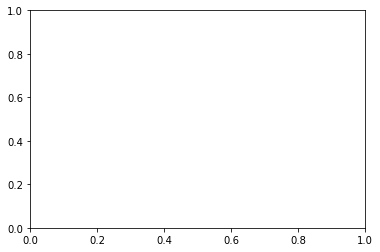

In [5]:


def plot_array(array,spatial_extent,colorlimit,ax=plt.gca(),title='',cmap_title='',colormap=''):
    plot = plt.imshow(array,extent=spatial_extent,clim=colorlimit); 
    cbar = plt.colorbar(plot,aspect=40); plt.set_cmap(colormap); 
    cbar.set_label(cmap_title,rotation=90,labelpad=20);
    plt.title(title); ax = plt.gca(); 
    ax.ticklabel_format(useOffset=False, style='plain'); 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90);

# clipping section

In [31]:
# create a folder for the clipped rasters

clipped_nitrogen_path = os.path.join(et.io.HOME, 
                             'desktop', 
                             'earth-analytics', 
                             'python', 
                             'watersheds-biodiversity', 
                             'clipped-rasters', 
                             'nitrogen')

nitrogen_clipped_to_mosaic = glob.glob(os.path.join(str(clipped_nitrogen_path), "*.tif"))


In [28]:
# This command only needs to run once in order to write raster files so that's why it is commented out

# produces a clipped raster file for each original raster file and saves it according to path


#for image, i in zip(nitrogen_to_mosaic, range(0,10)):
#    nitrogen_clip_gdal = gdal.Warp(clipped_nitrogen_path+'/nitrogen-rr-hu8-clip{}.tif'.format(i), 
#    image, 
#    cutlineDSName=clip_path,
#    cropToCutline=True,
#    dstNodata = 0)

# mosaic section

In [91]:
# reduce overlapping data by reading in rasters in a new order

order3 = [5, 6, 3, 4, 8, 9, 0, 7, 2, 1]



# list of paths to clipped rasters
nitrogen_clip_order3 = [nitrogen_clipped_to_mosaic[i] for i in order3]

# convert list of paths to a string because gdal merge takes in a string argument
string_nitrogen_clipped_to_mosaic = " ".join(nitrogen_clip_order3)


In [92]:
# path to mosaiced file to be written in the following command

mosaic_gdal_order3 = os.path.join(et.io.HOME,
                           'desktop',
                           'earth-analytics',
                           'python',
                           'watersheds-biodiversity',
                           'mosaics', 
                           'nitrogen', 
                           'nitrogen-mosaic-order3.tif')

In [97]:
# # This command only needs to run once in order to write the raster file so that's why it is commented out

# merge clipped rasters and output a mosaiced raster

#command_nitrogen = "gdal_merge.py -o /Users/merielle/desktop/earth-analytics/python/watersheds-biodiversity/mosaics/nitrogen/nitrogen-mosaic-order3.tif -of gtiff " + string_nitrogen_clipped_to_mosaic

#print(os.popen(command_nitrogen).read())



# rasters to arrays

In [94]:
# convert rasters to arrays

nitrogen_order3, nitrogen_order3_metadata = raster2array(
    mosaic_gdal_order3)

<function matplotlib.pyplot.show(close=None, block=None)>

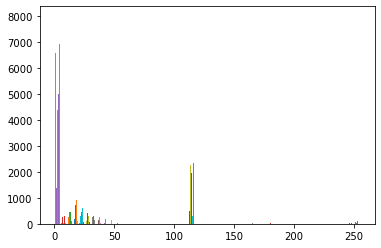

In [44]:
plt.hist(nitrogen_order[:,:,0],bins=50)
plt.show


In [95]:
# create a mask for values between flight paths

# generate a list of all unique elements in the array 
unique_elements, counts_elements = np.unique(nitrogen_order3, return_counts=True)
# pixel counts are suspiciously high for one value
np.where(counts_elements == 4635083)

# convert array elements to floats in order to set outlier value to nan 
nitrogen_order3_floats = nitrogen_order3.astype(float)
# set value 113 to nan
nitrogen_order3_floats[np.where(nitrogen_order3_floats==113)]=np.nan

# map plotting section

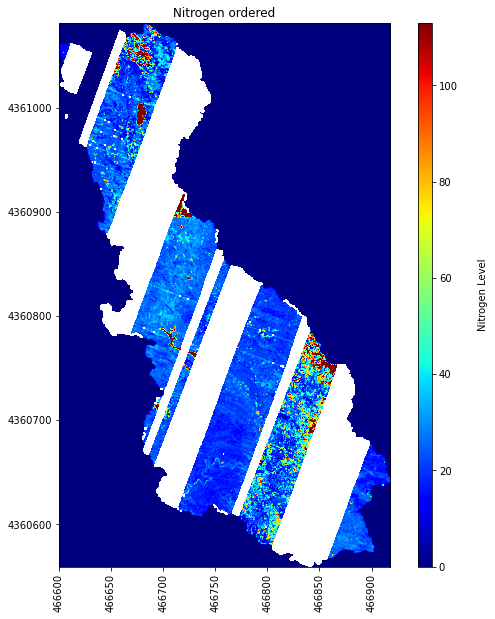

In [96]:
fig, ax = plt.subplots(figsize=(10,10))


plot_array(nitrogen_order2_floats[:,:,0],
           nitrogen_order2_metadata['extent'],
           (0,113),
           title='Nitrogen ordered',
           cmap_title='Nitrogen Level',
           colormap='jet')